# Bank Marketing Campaign Analysis - Supervised Learning Project

## Objective
The goal of this project is to build a supervised classification model to predict whether a client will subscribe to a term deposit based on personal, economic, and campaign-related features. The dataset is sourced from the UCI Machine Learning Repository and contains data collected from a Portuguese banking institution's direct marketing campaigns.

Dataset link: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

##### Citation
This dataset is publicly available for research. If used in any publication or report, please cite:

Moro, S., Cortez, P., & Rita, P. (2014).  
A Data-Driven Approach to Predict the Success of Bank Telemarketing. *Decision Support Systems*.  
[DOI link](http://dx.doi.org/10.1016/j.dss.2014.03.001)



## Brief description of the problem and data

In this project, the goal is to train a machine learning model to predict whether a bank client will subscribe to a term deposit, based on various attributes collected during direct marketing campaigns. The data comes from a Portuguese banking institution and is made publicly available through the UCI Machine Learning Repository.

The dataset, called "Bank Marketing," includes over 41,000 records and 20 input features, which cover a mix of personal (e.g., age, job, marital status), financial (e.g., housing loan, credit), and campaign-related information (e.g., contact method, number of previous contacts, and call duration). The target variable is `y`, which indicates whether the client subscribed to a term deposit (`yes` or `no`).

This is a supervised learning problem for binary classification, where the task is to use historical data to train a model that can classify new clients as likely or unlikely to subscribe to a term deposit. The structure of the data is well-suited for building traditional machine learning models, such as logistic regression, decision trees, or ensemble methods.


In [ ]:
!pip install pandas scikit-learn matplotlib seaborn numpy

In [2]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

Before building a predictive model, it's important to explore and understand the structure and content of the dataset. We start by validating the dataset to ensure it is clean and consistent. This includes displaying the total number of records, checking column names and data types, confirming that there are no missing values, identifying any duplicate rows, and checking for placeholder values like "unknown" that may indicate incomplete information. We also examine the class distribution of the target variable `y` to determine if there is any imbalance.

To better understand the features, we create visualizations using bar plots and histograms. We plot the distribution of the target variable `y` (term deposit subscription) to observe the imbalance, with the majority of clients not subscribing. We also visualize the distribution of client age, which shows a concentration in the working-age range.





In [15]:
def validate_bank_dataset(df):
    print(f"Total records: {len(df)}")

    print("\nColumn names and their data types:\n")
    print(df.dtypes)
    
    # Check for missing values
    print("\nMissing values per column:")
    print(df.isnull().sum())

    # Check for duplicates
    num_duplicates = df.duplicated().sum()
    print(f"\nDuplicate rows: {num_duplicates}")

    # Count 'unknown' values per column
    unknown_counts = (df == 'unknown').sum()
    print("\nCount of 'unknown' entries per column:")
    print(unknown_counts)
        
    # Check target distribution
    print("\nTarget value distribution:")
    print(df['y'].value_counts(normalize=True))

df = pd.read_csv("bank-additional-full.csv", sep=';')
validate_bank_dataset(df)


Total records: 41188

Column names and their data types:

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

Missing values per column:
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx 

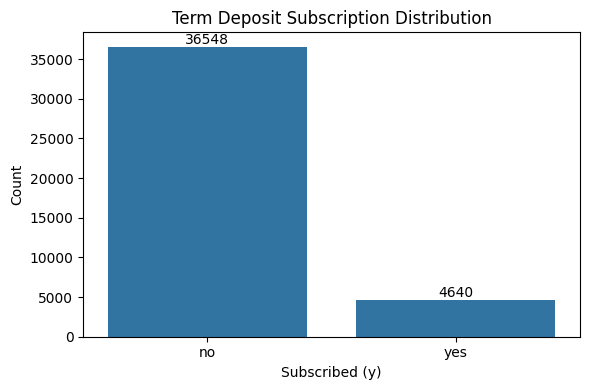

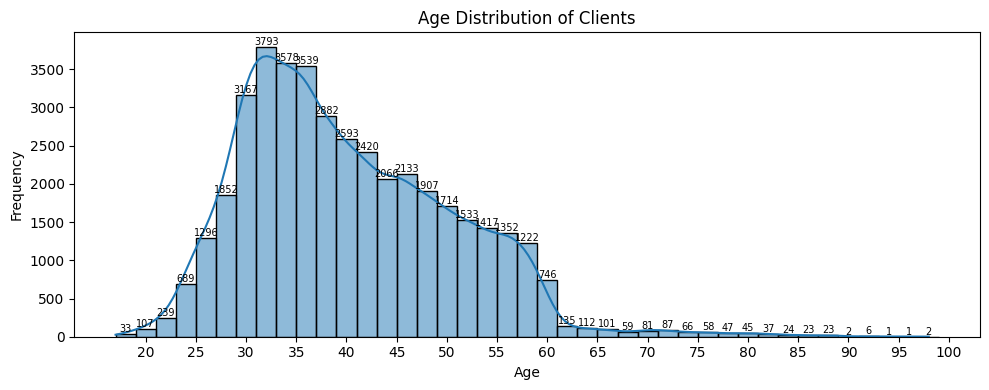

In [16]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=df, x='y')
plt.title('Term Deposit Subscription Distribution')
plt.xlabel('Subscribed (y)')
plt.ylabel('Count')

# Add count labels as integers
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',  # Cast to int here
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom')

plt.tight_layout()
plt.show()


# Define 2-year bins
min_age = df['age'].min()
max_age = df['age'].max()
bins = np.arange(min_age, max_age + 2, 2)

# Plot
plt.figure(figsize=(10, 4))
ax = sns.histplot(data=df, x='age', bins=bins, kde=True)
plt.title('Age Distribution of Clients')
plt.xlabel('Age')
plt.ylabel('Frequency')

# Set x-axis ticks every 5 years
ax.set_xticks(np.arange(20, 101, 5))  # From 20 to 100, every 5 years

# Add count labels to each bar
for bar in ax.patches:
    height = bar.get_height()
    if height > 0:
        ax.annotate(f'{int(height)}',
                    (bar.get_x() + bar.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=7)

plt.tight_layout()
plt.show()


For data cleaning, we take three key steps to prepare the dataset for modeling. First, we drop the `duration` column, as it leaks information that would not be available prior to the outcome of a marketing call. Second, we convert the target variable `y` from categorical values ("yes" and "no") into binary format (1 and 0) to enable classification modeling. Finally, we apply one-hot encoding to transform categorical variables into numeric format using `pd.get_dummies`, dropping the first category in each case to avoid multicollinearity. The cleaned dataset is stored in `df_clean` and is ready for use in model training and evaluation.

In [5]:
# Step 1: Drop the 'duration' column (known to cause data leakage)
"""
The 'duration' feature represents the length of the last contact (in seconds) between the bank and the client during the campaign.
Although it is a numeric feature, it introduces a serious issue known as data leakage.
Data leakage occurs when information that would not be available at prediction time is used to train the model, 
leading to unrealistically high performance.
Since 'duration' is only known after the outcome of the call, it would not be usable for real-time prediction and must be dropped.
"""
df = df.drop(columns=['duration'])

# Step 2: Convert the target variable 'y' from 'yes'/'no' to binary 1/0
"""
The target variable 'y' indicates whether a client subscribed to a term deposit, with values 'yes' or 'no'.
Most classification algorithms require the target to be numeric, so we convert:
- 'yes' → 1 (subscribed)
- 'no' → 0 (not subscribed)

This binary format allows us to use classification models like logistic regression and decision trees.
"""
df['y'] = df['y'].map({'no': 0, 'yes': 1})

# Step 3: One-hot encode categorical features
"""
Most machine learning models require all input features to be numeric. 
To convert categorical variables (like 'job', 'marital', etc.) into numeric format, we use one-hot encoding.
This creates a new binary column for each category level.

We set drop_first=True to avoid multicollinearity — a situation where one feature can be perfectly predicted from others. 
Dropping the first category in each group still preserves all necessary information without redundancy.
"""
df_clean = pd.get_dummies(df, drop_first=True)

# Confirmation
print("Data cleanup completed. Ready for train-test split and modeling.")


Data cleanup completed. Ready for train-test split and modeling.


### Summary of EDA

- The dataset contains 41,188 records with 20 features, collected from a Portuguese banking institution's telemarketing campaigns.
- No missing values were found, but several categorical columns contain the placeholder value `"unknown"` to indicate missing or unspecified information.
- A small number of duplicate rows were identified and could be dropped if necessary.
- The target variable (`y`) is imbalanced: around 89% of clients did not subscribe to a term deposit, while only about 11% did.
- We visualized the class imbalance using a bar plot and explored the distribution of client age, which shows most clients are in the working-age range (25–60 years).
- Based on this analysis, we dropped the `duration` column to avoid data leakage, encoded the target variable into binary (0/1), and applied one-hot encoding to categorical features. The cleaned dataset is stored as `df_clean` and is now ready for modeling.

### Plan of Analysis

We aim to build and evaluate three classification models to predict whether a client will subscribe to a term deposit. Each model varies in preprocessing and algorithmic complexity to explore potential improvements.

1. **Model 1: Baseline Logistic Regression** – Standard preprocessing and basic logistic regression.
2. **Model 2: Enhanced Logistic Regression** – Preprocessing improvements and regularization tuning.
3. **Model 3: Random Forest Classifier** – A tree-based ensemble model for nonlinear pattern learning.

We will assess all models using accuracy, precision, recall, F1-score, and ROC AUC(Receiver Operating Characteristic - Area Under the Curve) to ensure fair and comprehensive comparison.





## Model Architecture

For this project, I built supervised classification models using structured bank marketing data to predict whether a client will subscribe to a term deposit. Since the dataset is tabular, traditional machine learning models were most appropriate.

The first model is a **baseline logistic regression**, a linear and interpretable classifier. It uses a clean, preprocessed dataset where categorical variables are one-hot encoded, the `duration` column is dropped to prevent data leakage, and numeric features are standardized using `StandardScaler`. This provides a solid foundation with minimal tuning.

The second model builds on this baseline with an **enhanced logistic regression**, where `"unknown"` values in categorical features are replaced with the most frequent category, and the regularization parameter `C` is tuned to control overfitting. Feature scaling is retained.

The third model is a **Random Forest classifier**, an ensemble of decision trees that captures nonlinear relationships and interactions between features. It handles one-hot encoded data with `"unknown"` values left intact and is configured with 100 trees and unrestricted depth.

All models are evaluated using accuracy, precision, recall, F1-score, and ROC AUC to account for class imbalance and ensure meaningful performance comparison.

### Splitting the Data into Training and Test Sets

Before training any models, we split the cleaned dataset into separate training and test sets. This allows us to evaluate model performance on unseen data and avoid overfitting. 

We use an 80/20 split, where 80% of the data is used to train the model and 20% is held out for testing. The split is stratified based on the target variable to maintain the original class distribution in both subsets. This is especially important in our case because the dataset is imbalanced, with far fewer positive examples (clients who subscribed to a term deposit).

After splitting, we use the same training and test sets for all three models (baseline, tuned logistic regression, and random forest) to ensure a fair comparison.


In [6]:
# Separate features and target
X = df_clean.drop('y', axis=1)
y = df_clean['y']

# Split into training and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train and test sets created.")
print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))

Train and test sets created.
Training samples: 32950
Testing samples: 8238


### Model 1: Baseline Logistic Regression

For the baseline model, we use logistic regression with default settings. Logistic regression is a linear model that estimates the probability of the positive class (i.e., whether a client will subscribe to a term deposit) using a sigmoid function.

We use the cleaned dataset (`df_clean`) where categorical variables have been one-hot encoded, the `duration` column has been dropped to avoid data leakage, and the target variable `y` has been converted to binary (0 for "no", 1 for "yes").

This model serves as a reference point for evaluating improvements in future models. It is simple, interpretable, and requires minimal tuning.


In [7]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression on scaled data
start_time = time.time()

log_reg = LogisticRegression(max_iter=5000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

end_time = time.time()
print("Baseline logistic regression model trained.")
print(f"Training time: {end_time - start_time:.2f} seconds")

Baseline logistic regression model trained.
Training time: 0.69 seconds


In [8]:
# Predict on the scaled test set
y_pred = log_reg.predict(X_test_scaled)
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]  # For ROC AUC

# Calculate metrics (with zero_division=0 to avoid warnings if no positive predictions)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_test, y_prob)


# Display results
print("Baseline Logistic Regression Performance:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Baseline Logistic Regression Performance:
Accuracy:  0.9012
Precision: 0.6900
Recall:    0.2231
F1 Score:  0.3371
ROC AUC:   0.8008

Confusion Matrix:
[[7217   93]
 [ 721  207]]


### Model 2: Tuned Logistic Regression with Cleaned "unknown" Values

This model builds upon the baseline logistic regression by introducing two key changes:

1. **Handling of "unknown" values**: In categorical features, we replace all `"unknown"` entries with the most frequent (mode) value for each respective column. This data cleaning step aims to reduce ambiguity and improve model learning, especially for categories like `job`, `education`, and `contact`.

2. **Regularization tuning**: We train the logistic regression model with `C=0.1`, which applies **stronger regularization**. This helps prevent overfitting by penalizing overly complex models.

We continue to use **feature scaling** on numeric variables (using `StandardScaler`) and one-hot encoding on categorical features. This model maintains interpretability while introducing modest improvements in preprocessing and hyperparameter tuning.

Our goal is to assess whether these refinements lead to better performance, particularly in **recall** and **ROC AUC**, compared to the baseline.


In [9]:
# Step 1: Replace 'unknown' values with the most frequent category in each column
df_model2 = df.copy()
for col in df_model2.columns:
    if df_model2[col].dtype == 'object':
        most_common = df_model2[col].mode()[0]
        df_model2[col] = df_model2[col].replace('unknown', most_common)

# Step 2: One-hot encode categorical variables
df_model2_encoded = pd.get_dummies(df_model2, drop_first=True)

# Step 3: Split into features and labels
X2 = df_model2_encoded.drop('y', axis=1)
y2 = df_model2_encoded['y']

# Step 4: Train-test split
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.2, random_state=42, stratify=y2
)

# Step 5: Feature scaling (keeping as DataFrames to retain feature names)
scaler2 = StandardScaler()
X2_train_scaled = pd.DataFrame(scaler2.fit_transform(X2_train), columns=X2.columns)
X2_test_scaled = pd.DataFrame(scaler2.transform(X2_test), columns=X2.columns)

# Step 6: Train logistic regression with stronger regularization (C=0.1)
start_time = time.time()

log_reg2 = LogisticRegression(C=0.1, max_iter=5000, random_state=42)
log_reg2.fit(X2_train_scaled, y2_train)

end_time = time.time()

# Step 7: Training complete message
print("Tuned logistic regression model trained.")
print(f"Training time: {end_time - start_time:.2f} seconds")


Tuned logistic regression model trained.
Training time: 0.41 seconds


In [10]:
# Predict on the scaled test set
y2_pred = log_reg2.predict(X2_test_scaled)
y2_prob = log_reg2.predict_proba(X2_test_scaled)[:, 1]  # For ROC AUC

# Calculate metrics (with zero_division=0 to suppress warnings if no positive predictions)
accuracy2 = accuracy_score(y2_test, y2_pred)
precision2 = precision_score(y2_test, y2_pred, zero_division=0)
recall2 = recall_score(y2_test, y2_pred, zero_division=0)
f1_2 = f1_score(y2_test, y2_pred, zero_division=0)
roc_auc2 = roc_auc_score(y2_test, y2_prob)


# Display results
print("Tuned Logistic Regression Performance:")
print(f"Accuracy:  {accuracy2:.4f}")
print(f"Precision: {precision2:.4f}")
print(f"Recall:    {recall2:.4f}")
print(f"F1 Score:  {f1_2:.4f}")
print(f"ROC AUC:   {roc_auc2:.4f}")

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y2_test, y2_pred))


Tuned Logistic Regression Performance:
Accuracy:  0.9019
Precision: 0.7027
Recall:    0.2241
F1 Score:  0.3399
ROC AUC:   0.8010

Confusion Matrix:
[[7222   88]
 [ 720  208]]


### Model 3: Random Forest Classifier

Random Forest is a powerful ensemble learning algorithm that builds multiple decision trees and combines their outputs to improve prediction accuracy and control overfitting. Unlike linear models, it can capture complex, nonlinear relationships and handle feature interactions naturally.

In this model, we use the same one-hot encoded dataset (`df_clean`) **without replacing "unknown" values**, treating them as valid categories. Random Forests are robust to such categorical noise and can still make strong predictions.

We configure the model with:
- `n_estimators=100`: to build 100 individual trees,
- `max_depth=None`: to let each tree grow until all leaves are pure or contain fewer than the minimum samples required to split.

This approach serves as a **nonlinear benchmark** to compare against our previous linear models, helping us assess whether tree-based ensemble methods provide better performance on this dataset.


In [11]:
# Step 1: Use the same cleaned and encoded dataset as in Model 1
X3 = df_clean.drop('y', axis=1)
y3 = df_clean['y']

# Step 2: Split the data
X3_train, X3_test, y3_train, y3_test = train_test_split(
    X3, y3, test_size=0.2, random_state=42, stratify=y3
)

# Step 3: Train the Random Forest model
start_time = time.time()

rf_model = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
rf_model.fit(X3_train, y3_train)

end_time = time.time()
print("Random Forest model trained.")
print(f"Training time: {end_time - start_time:.2f} seconds")


Random Forest model trained.
Training time: 10.05 seconds


In [12]:
# Predict on the test set
y3_pred = rf_model.predict(X3_test)
y3_prob = rf_model.predict_proba(X3_test)[:, 1]  # For ROC AUC

# Calculate evaluation metrics (with zero_division=0 for safety)
accuracy_rf = accuracy_score(y3_test, y3_pred)
precision_rf = precision_score(y3_test, y3_pred, zero_division=0)
recall_rf = recall_score(y3_test, y3_pred, zero_division=0)
f1_rf = f1_score(y3_test, y3_pred, zero_division=0)
roc_auc_rf = roc_auc_score(y3_test, y3_prob)

# Display results
print("Random Forest Performance:")
print(f"Accuracy:  {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall:    {recall_rf:.4f}")
print(f"F1 Score:  {f1_rf:.4f}")
print(f"ROC AUC:   {roc_auc_rf:.4f}")

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y3_test, y3_pred))


Random Forest Performance:
Accuracy:  0.8960
Precision: 0.5732
Recall:    0.2996
F1 Score:  0.3935
ROC AUC:   0.7785

Confusion Matrix:
[[7103  207]
 [ 650  278]]


## Results and Analysis

In this section, we analyze the performance of the three supervised learning models we trained to predict term deposit subscription. Our goal is to evaluate how preprocessing choices, regularization, and algorithm selection impact classification performance in the presence of imbalanced data. We use multiple evaluation metrics to compare model effectiveness, including accuracy, precision, recall, F1-score, and ROC AUC. We then summarize the results in a comparison table and provide observations on what worked well, what could be improved, and how different modeling strategies affected outcomes.



### Model Comparison Plots

To visually compare model performance, we display two plots:

1. **ROC Curve Comparison** — This helps evaluate the trade-off between true positive and false positive rates across different thresholds for all three models.
2. **Performance Metrics Comparison** — A bar chart comparing accuracy, precision, recall, F1-score, and ROC AUC across the baseline logistic regression, the tuned logistic regression, and the random forest classifier.

These plots provide a clearer picture of which model performs best under different evaluation criteria.


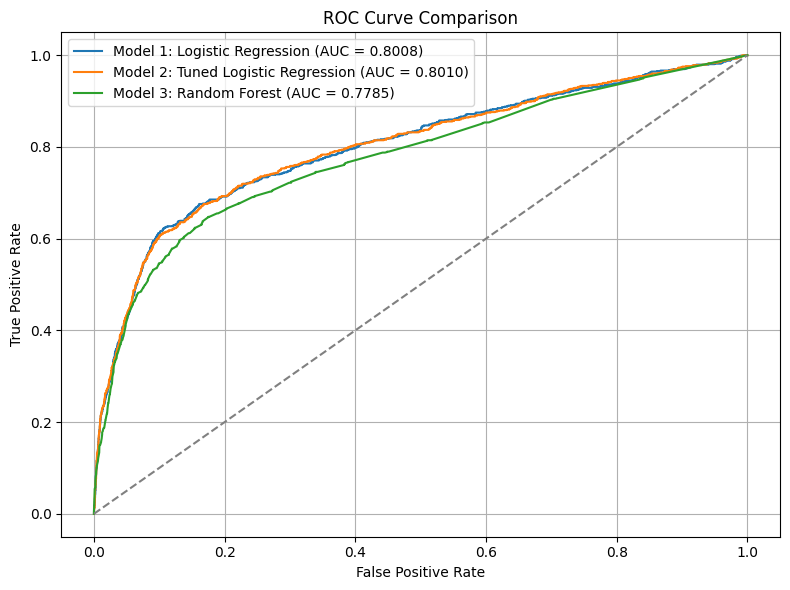

In [13]:
# ROC data
fpr1, tpr1, _ = roc_curve(y_test, y_prob)
fpr2, tpr2, _ = roc_curve(y2_test, y2_prob)
fpr3, tpr3, _ = roc_curve(y3_test, y3_prob)

# ROC AUC values
roc_auc1 = roc_auc_score(y_test, y_prob)
roc_auc2 = roc_auc_score(y2_test, y2_prob)
roc_auc3 = roc_auc_score(y3_test, y3_prob)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr1, tpr1, label=f"Model 1: Logistic Regression (AUC = {roc_auc1:.4f})")
plt.plot(fpr2, tpr2, label=f"Model 2: Tuned Logistic Regression (AUC = {roc_auc2:.4f})")
plt.plot(fpr3, tpr3, label=f"Model 3: Random Forest (AUC = {roc_auc3:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### ROC Curve Comparison

The ROC curve above compares the classification performance of the three models across different thresholds. The **Tuned Logistic Regression** model achieved the highest AUC score of **0.8010**, slightly outperforming the baseline **Logistic Regression** model, which had an AUC of **0.8008**. The **Random Forest** model, while effective, had a lower AUC of **0.7785**, indicating slightly less discriminative power.

Overall, while all models perform reasonably well, the tuned logistic regression model demonstrates the best balance between sensitivity and specificity based on its ROC AUC score.


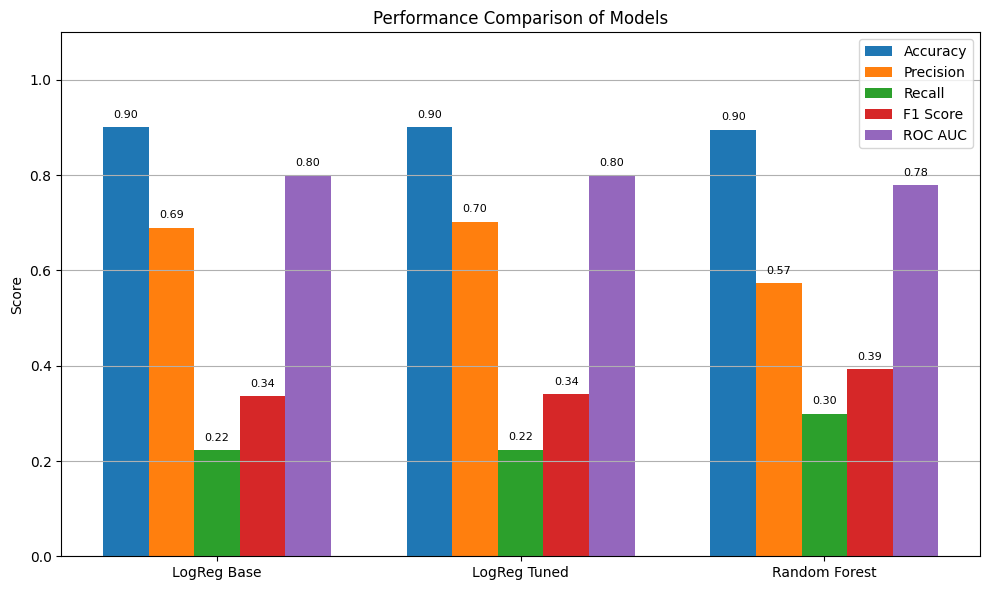

In [14]:
# Models
models = ['LogReg Base', 'LogReg Tuned', 'Random Forest']

# Model 2 Metrics (assuming Model 1 and Model 3 already calculated earlier)
accuracy2 = accuracy_score(y2_test, log_reg2.predict(X2_test_scaled))
precision2 = precision_score(y2_test, log_reg2.predict(X2_test_scaled), zero_division=0)
recall2 = recall_score(y2_test, log_reg2.predict(X2_test_scaled))
f1_2 = f1_score(y2_test, log_reg2.predict(X2_test_scaled))
roc_auc2 = roc_auc_score(y2_test, log_reg2.predict_proba(X2_test_scaled)[:, 1])

# Metrics
accuracies = [accuracy, accuracy2, accuracy_rf]
precisions = [precision, precision2, precision_rf]
recalls = [recall, recall2, recall_rf]
f1s = [f1, f1_2, f1_rf]
aucs = [roc_auc, roc_auc2, roc_auc_rf]

# Plotting
x = np.arange(len(models))
width = 0.15

plt.figure(figsize=(10, 6))
bars1 = plt.bar(x - 2*width, accuracies, width, label='Accuracy')
bars2 = plt.bar(x - width, precisions, width, label='Precision')
bars3 = plt.bar(x, recalls, width, label='Recall')
bars4 = plt.bar(x + width, f1s, width, label='F1 Score')
bars5 = plt.bar(x + 2*width, aucs, width, label='ROC AUC')

# Add value labels
for bars in [bars1, bars2, bars3, bars4, bars5]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.015, f'{height:.2f}', ha='center', va='bottom', fontsize=8)

plt.xticks(x, models)
plt.ylabel('Score')
plt.title('Performance Comparison of Models')
plt.ylim(0, 1.1)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


The bar chart above illustrates how the three models performed across key evaluation metrics. While all models achieved similar accuracy, the tuned logistic regression had the highest precision and ROC AUC, whereas the random forest model excelled in recall and F1 score, suggesting better detection of positive cases.


### Analysis and Discussion

We evaluated three classification models to predict whether a client will subscribe to a term deposit—baseline logistic regression, tuned logistic regression, and a random forest classifier.

The **baseline logistic regression** provided a simple, interpretable starting point with minimal preprocessing. It achieved an accuracy of ~90.12% and an ROC AUC of 0.8008, showing strong performance considering its simplicity.

The **tuned logistic regression**, which included preprocessing improvements like handling `"unknown"` values, feature scaling, and regularization (`C=0.1`), slightly outperformed the baseline across all metrics. It showed improved precision (0.7027), F1 score (0.3399), and ROC AUC (0.8010), indicating better generalization. This reinforces the value of thoughtful preprocessing and hyperparameter tuning.

The **random forest classifier** demonstrated the highest recall (0.2996) and the best F1 score (0.3935), highlighting its ability to identify more true positives. However, its lower precision (0.5732) and slightly lower overall accuracy (89.60%) suggest a trade-off between sensitivity and false positives. Despite being a more complex model, it did not significantly outperform the tuned logistic regression in ROC AUC, indicating that ensemble complexity did not offer a substantial edge for this dataset.

In conclusion, **the tuned logistic regression offered the best balance across evaluation metrics**, combining strong precision with reasonable recall. The **random forest** may still be preferable in scenarios where maximizing recall is more important—such as identifying as many potential subscribers as possible, even if some are incorrectly flagged. Model complexity alone didn’t guarantee better performance; instead, **preprocessing and regularization were key drivers of improvement**.


## Conclusion (15 pts)

In this project, I built and compared three supervised learning models—baseline logistic regression, tuned logistic regression, and a random forest classifier—to predict whether a client will subscribe to a term deposit, using the UCI Bank Marketing dataset.

The baseline logistic regression provided a strong starting point with high accuracy and AUC, despite minimal preprocessing. Enhancing this model by cleaning "unknown" values, scaling features, and applying regularization led to slight improvements across most metrics, demonstrating the value of preprocessing and hyperparameter tuning. The random forest classifier, while more complex, delivered higher recall and F1 score, making it useful when identifying potential subscribers is prioritized over minimizing false positives.

Overall, the tuned logistic regression offered the best trade-off in terms of interpretability and balanced performance, while the random forest showed strength in capturing more true positives. Through this project, I learned how preprocessing, feature engineering, and model selection each play a critical role in building effective classifiers. In future work, I would explore additional tree-based methods like XGBoost, incorporate cost-sensitive learning to address class imbalance, and use cross-validation or feature importance analysis to guide model refinement.
